In [ ]:
from numpy import array
from numpy import arange
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
import pandas as pd
import polars as pl

# load data

In [ ]:
spike_mat = pl.read_csv("superchris_odor_spike_mat.csv")

print(spike_mat.head())

# Select neural data only
neural_name = spike_mat.columns[5:]
neural_spike = spike_mat.select(neural_name)  # Replace with your numeric column names
neural_spike_np = neural_spike.to_numpy()
print(neural_spike.head())

shape: (5, 51)
┌──────────────┬──────┬────────────┬────────┬───┬────────┬───────┬───────┬───────┐
│              ┆ odor ┆ TimeBin    ┆ seq_id ┆ … ┆ T23-U7 ┆ T7-U1 ┆ T8-U1 ┆ T9-U1 │
│ ---          ┆ ---  ┆ ---        ┆ ---    ┆   ┆ ---    ┆ ---   ┆ ---   ┆ ---   │
│ str          ┆ i64  ┆ f64        ┆ i64    ┆   ┆ i64    ┆ i64   ┆ i64   ┆ i64   │
╞══════════════╪══════╪════════════╪════════╪═══╪════════╪═══════╪═══════╪═══════╡
│ Odor1.168555 ┆ 1    ┆ 168.555075 ┆ 3      ┆ … ┆ 0      ┆ 0     ┆ 0     ┆ 0     │
│ Odor1.168556 ┆ 1    ┆ 168.556075 ┆ 3      ┆ … ┆ 0      ┆ 0     ┆ 0     ┆ 0     │
│ Odor1.168557 ┆ 1    ┆ 168.557075 ┆ 3      ┆ … ┆ 0      ┆ 0     ┆ 0     ┆ 0     │
│ Odor1.168558 ┆ 1    ┆ 168.558075 ┆ 3      ┆ … ┆ 0      ┆ 0     ┆ 0     ┆ 0     │
│ Odor1.168559 ┆ 1    ┆ 168.559075 ┆ 3      ┆ … ┆ 0      ┆ 0     ┆ 0     ┆ 0     │
└──────────────┴──────┴────────────┴────────┴───┴────────┴───────┴───────┴───────┘
shape: (5, 46)
┌───────┬───────┬───────┬────────┬───┬────────┬───────┬──

# EDA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Standardize the data
scaler = StandardScaler()
neural_spike_scaled = scaler.fit_transform(neural_spike_np)
print(neural_spike_scaled.shape)

(281329, 46)


## PCA?

In [ ]:

# Perform PCA (e.g., reduce to 2 components)
pca = PCA(n_components=2)
spike_pc2 = pca.fit_transform(neural_spike_scaled)

print(spike_pc2)
print(spike_pc2.shape)

[[ 0.20102425  2.82249259]
 [-0.05226173 -0.77885367]
 [-0.03398427 -0.28593043]
 ...
 [-0.06072317 -0.41974411]
 [-0.03398427 -0.28593043]
 [-0.03398427 -0.28593043]]
(281329, 2)


# Data Process

In [156]:
neural_data=np.loadtxt('superchris_odor_spike_mat.csv',delimiter=',',skiprows=6,usecols=range(5,51))
odor_data = np.loadtxt('superchris_odor_spike_mat.csv',delimiter=',',skiprows=6,usecols=[1,4])

# Initialize lists to hold trial-wise batches
spike_data_batches = []
odor_data_batches = []

# Iterate over unique trials in `odor_data`
for i_trial in np.unique(odor_data[:, 1]):  # Assuming trial info is in column 1
    # Extract the rows corresponding to the current trial
    neural_data_i_trial = neural_data[odor_data[:, 1] == i_trial]

    # Perform binning
    remainder = neural_data_i_trial.shape[0] % time_bin
    if remainder != 0: 
        neural_bins_subset = neural_data_i_trial[:-remainder, :].reshape((-1, time_bin, 46))
    else: 
        neural_bins_subset = neural_data_i_trial.reshape((-1, time_bin, 46))

    # Sum the bins
    neural_bins_sum = np.sum(neural_bins_subset, axis=1)

    # Append spike data and labels for this trial
    spike_data_batches.append(torch.from_numpy(neural_bins_sum))  # Convert to torch.Tensor
    #odor_label = np.zeros(neural_bins_sum.shape[0])
    #odor_label[:] = np.unique(odor_data[np.where(odor_data[:, 1] == i_trial), 0])
    odor_data_batches.append(torch.from_numpy(np.unique(odor_data[np.where(odor_data[:, 1] == i_trial), 0])))

# Combine into batched tensors
print(f"Number of batches: {len(spike_data_batches)}")
for i, (spike_batch, odor_batch) in enumerate(zip(spike_data_batches, odor_data_batches)):
    print(f"Batch {i}: Spike data shape {spike_batch.shape}, Odor label shape {odor_batch.shape}")

Number of batches: 210
Batch 0: Spike data shape torch.Size([69, 46]), Odor label shape torch.Size([1])
Batch 1: Spike data shape torch.Size([64, 46]), Odor label shape torch.Size([1])
Batch 2: Spike data shape torch.Size([64, 46]), Odor label shape torch.Size([1])
Batch 3: Spike data shape torch.Size([64, 46]), Odor label shape torch.Size([1])
Batch 4: Spike data shape torch.Size([59, 46]), Odor label shape torch.Size([1])
Batch 5: Spike data shape torch.Size([66, 46]), Odor label shape torch.Size([1])
Batch 6: Spike data shape torch.Size([58, 46]), Odor label shape torch.Size([1])
Batch 7: Spike data shape torch.Size([65, 46]), Odor label shape torch.Size([1])
Batch 8: Spike data shape torch.Size([65, 46]), Odor label shape torch.Size([1])
Batch 9: Spike data shape torch.Size([64, 46]), Odor label shape torch.Size([1])
Batch 10: Spike data shape torch.Size([59, 46]), Odor label shape torch.Size([1])
Batch 11: Spike data shape torch.Size([58, 46]), Odor label shape torch.Size([1])
Bat

# LSTM VAE

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers, hidden_size):
        super(LSTMModel, self).__init__()

        # Variables
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim

        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=input_dim,  # Dimension of continuous data
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first = True
        )

        # Latent space transformation
        self.mean = nn.Linear(in_features=hidden_size, out_features=latent_dim)
        self.log_variance = nn.Linear(in_features=hidden_size, out_features=latent_dim)

        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(
            input_size=latent_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Reconstruction from LSTM output
        self.output_layer = nn.Linear(in_features=hidden_size, out_features=input_dim)

    def encode(self, x_list, lengths):
        """
        Encoder: Takes a list of input sequences with varying lengths and encodes them into latent space.
        x_list: List of tensors, each with shape (seq_len, input_dim).
        lengths: Tensor of sequence lengths (batch_size).
        """
        # Pad sequences to the same length and pack them
        x_padded = torch.nn.utils.rnn.pad_sequence(x_list, batch_first=True)  # (batch_size, max_seq_len, input_dim)
        packed_input = pack_padded_sequence(x_padded, lengths, batch_first=True, enforce_sorted=False)

        # Pass through LSTM
        packed_output, (hidden, _) = self.encoder_lstm(packed_input)

        # Unpack output (optional)
        _, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Use the last hidden state from the final layer
        hidden = hidden[-1]  # (batch_size, hidden_size)

        # Compute mean and log-variance for latent space
        mean = self.mean(hidden)  # (batch_size, latent_dim)
        logvar = self.log_variance(hidden)  # (batch_size, latent_dim)
        return mean, logvar
    def reparameterize(self, mean, logvar):
            """
            Reparameterization trick to sample from N(mean, var).
            """
            std = torch.exp(0.5 * logvar)
            epsilon = torch.randn_like(std)
            return mean + epsilon * std

    def decode(self, z, lengths):
        """
        Decoder: Reconstruct sequences from latent representation.
        z: (batch_size, latent_dim)
        lengths: Tensor of sequence lengths (batch_size).
        """
        # Repeat latent vector for the max sequence length
        max_seq_len = lengths.max().item()
        z_repeated = z.unsqueeze(1).repeat(1, max_seq_len, 1)  # (batch_size, max_seq_len, latent_dim)

        # Decode latent space through LSTM
        packed_z = pack_padded_sequence(z_repeated, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.decoder_lstm(packed_z)

        # Unpack the output
        lstm_out, _ = pad_packed_sequence(packed_output, batch_first=True)  # (batch_size, max_seq_len, hidden_size)

        # Reconstruction through output layer
        output = self.output_layer(lstm_out)  # (batch_size, max_seq_len, input_dim)
        return output

    def forward(self, x_list):
        """
        Forward pass: Encoder -> Reparameterize -> Decoder.
        x_list: List of tensors with varying lengths, each with shape (seq_len, input_dim).
        """
        # Calculate lengths of sequences
        lengths = torch.tensor([x.size(0) for x in x_list], dtype=torch.long)

        # Encode input to latent space
        mean, logvar = self.encode(x_list, lengths)

        # Reparameterize
        z = self.reparameterize(mean, logvar)

        # Decode latent vector back to input space
        reconstructed_x = self.decode(z, lengths)

        return reconstructed_x, mean, logvar, z
    


## call the model

In [ ]:
# Example inputs
batch_size = len(spike_data_batches)
input_dim = 46
hidden_dim = 128
latent_dim = 5
num_layers = 4

# Initialize the model
model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, num_layers=num_layers, hidden_size=hidden_dim)

# Data
spike_data_batches = [x.float() for x in spike_data_batches]
x = spike_data_batches

# Forward pass
reconstructed_x, mean, logvar, z = model(x)

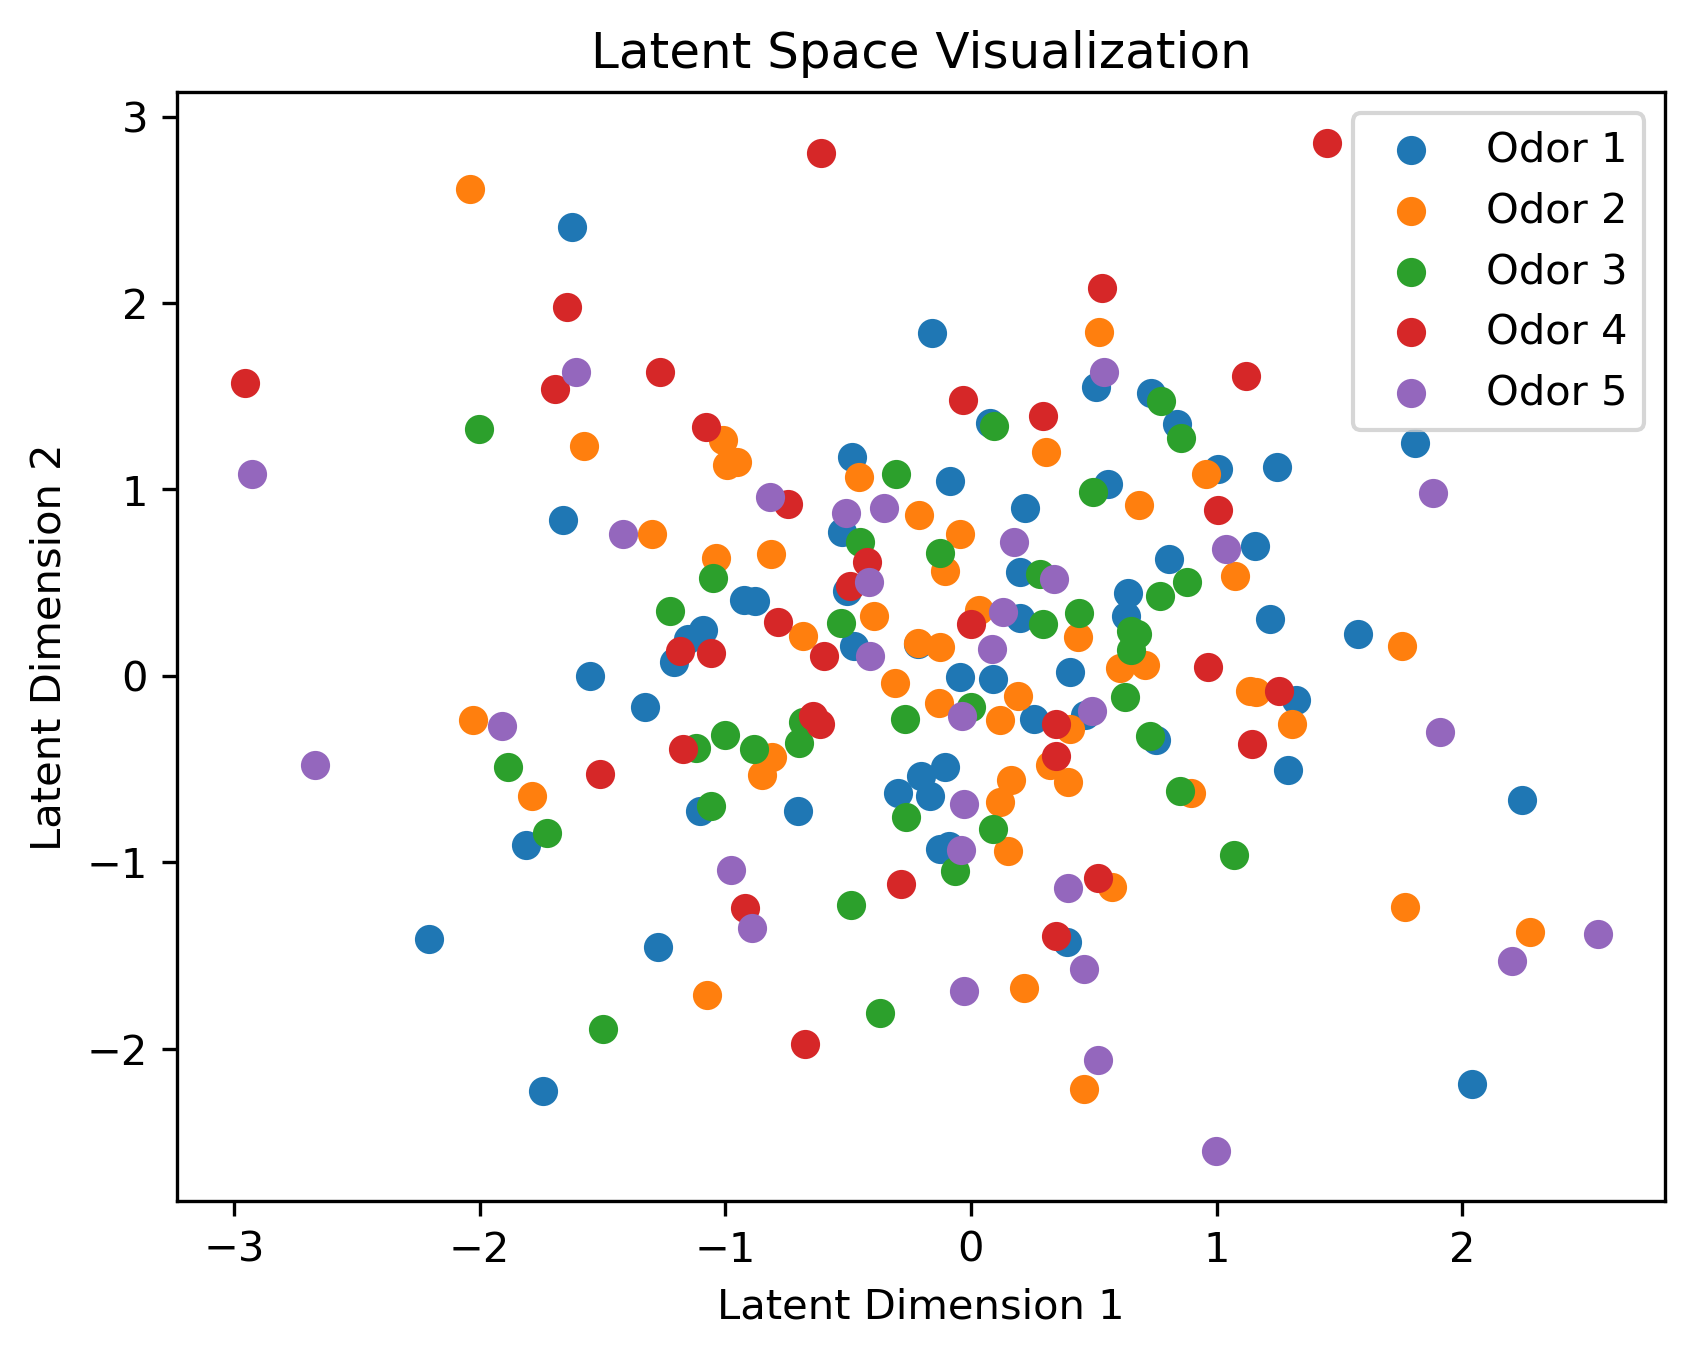

In [163]:
import matplotlib.pyplot as plt
# Assume `z` is the latent space output and `odor_data_final` is the label array
Latent_Space = z.detach().numpy()
# Concatenate all tensors in the list into a single tensor
odor_data_final_np = torch.cat(odor_data_batches).numpy() if isinstance(odor_data_batches[0], torch.Tensor) else np.concatenate(odor_data_batches)

plt.figure(dpi=300)
# Iterate through unique odor labels and plot points
unique_odors = np.unique(odor_data_final_np)  # Unique odor labels
for i in unique_odors:
    mask = odor_data_final_np == i  # Mask for points corresponding to odor i
    plt.scatter(Latent_Space[mask, 0], Latent_Space[mask, 1], label=f'Odor {int(i)}')

# Add legend and labels
plt.legend()
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Visualization")
plt.show()